In [1]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data, save_for_evaluation, process_train_test_data
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel


os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Data preparation

label
other-minor                 9805
meniskus-urgent             9312
cruciate-ligament-urgent    2388
meniskus-minor              1664
cruciate-ligament-minor      355
Name: count, dtype: int64


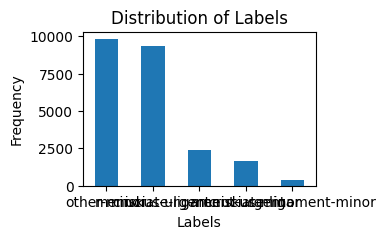

In [2]:
data_label = "data"
predict_label = "label"
balanced = False
labels = None
class_weights = False
sample_weights = False
df_train = pd.read_csv('../data/data_train.csv')
df_valid = pd.read_csv('../data/data_valid.csv')
df_test = pd.read_csv('../data/data_test.csv')

train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = process_train_test_data(df_train, df_valid, df_test, data_label, predict_label, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

# Model parameters

In [3]:
model_name = "tuner"

In [4]:
from utils import get_standard_parameters

optimizer, loss, metrics, early_stopping_callback, embedding_dim, lstm_units, epochs, batch_size = get_standard_parameters()

2024-07-29 09:44:41.589748: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-07-29 09:44:41.589787: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-07-29 09:44:41.589802: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-07-29 09:44:41.589826: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-29 09:44:41.589850: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Model definition and training

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner import HyperModel, BayesianOptimization
import keras_tuner

class LSTMHyperModel(HyperModel):
    def build(self, hp):
        # Define the input layer
        input_text = Input(shape=(max_length,), dtype='int32', name='text_input')
        
        # Embedding layer
        embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)
        
        # LSTM layers
        lstm_units = hp.Int('units', min_value=32, max_value=512, step=32)
        lstm_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)

        x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
        x = Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.8, step=0.1))(x)
        x = Bidirectional(LSTM(units=lstm_units2))(x)
        
        # Output layer
        output = Dense(num_classes, activation='softmax')(x)
        
        # Build and compile the model
        model = Model(inputs=input_text, outputs=output)
        model.compile(optimizer="adam", loss=loss, metrics=metrics)
        
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Int('batch', min_value=8, max_value=128, step=8),
            **kwargs,
        )

# Set up the tuner with the RandomSearch algorithm
tuner = BayesianOptimization(
    LSTMHyperModel(),
    objective=keras_tuner.Objective("val_f1_score", "max"),
    max_trials=10,
    executions_per_trial=1,
    directory='model_tuning',
    project_name='bayesian_opt2'
)

# Search for the best hyperparameters
tuner.search(train_padded, train_labels, 
             epochs=15, 
             validation_data=(valid_padded, valid_labels), 
             callbacks=[early_stopping_callback])

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters found:")
for hp in best_hps.space:
    print(f"{hp.name}: {best_hps.get(hp.name)}")

Trial 10 Complete [00h 26m 23s]
val_f1_score: 0.6130321621894836

Best val_f1_score So Far: 0.6130321621894836
Total elapsed time: 05h 28m 31s
Best hyperparameters found:
units: 512
units2: 448
dropout_1: 0.0
batch: 64


In [6]:
Trial 8 Complete [00h 23m 05s]
val_f1_score: 0.5156154036521912

Best val_f1_score So Far: 0.5306052565574646
Total elapsed time: 03h 12m 54s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
160               |224               |embedding_dim
128               |64                |units
0.7               |0                 |dropout_1
0.8               |0.1               |dropout_2

SyntaxError: invalid decimal literal (2798652407.py, line 1)

In [ ]:
tuner.results_summary()

Results summary
Results in model_tuning/LSTM_Classification
Showing 10 best trials
Objective(name="val_f1_score", direction="max")

Trial 04 summary
Hyperparameters:
embedding_dim: 224
units: 64
dropout_1: 0.0
dropout_2: 0.1
Score: 0.5306052565574646

Trial 03 summary
Hyperparameters:
embedding_dim: 224
units: 160
dropout_1: 0.0
dropout_2: 0.4
Score: 0.524086058139801

Trial 05 summary
Hyperparameters:
embedding_dim: 224
units: 128
dropout_1: 0.2
dropout_2: 0.6000000000000001
Score: 0.5198468565940857

Trial 07 summary
Hyperparameters:
embedding_dim: 224
units: 160
dropout_1: 0.8
dropout_2: 0.7000000000000001
Score: 0.5156154036521912

Trial 01 summary
Hyperparameters:
embedding_dim: 224
units: 224
dropout_1: 0.1
dropout_2: 0.7000000000000001
Score: 0.5087063908576965

Trial 02 summary
Hyperparameters:
embedding_dim: 160
units: 416
dropout_1: 0.6000000000000001
dropout_2: 0.7000000000000001
Score: 0.489473432302475

Trial 08 summary
Hyperparameters:
embedding_dim: 160
units: 128
dropou

In [ ]:
save_for_evaluation(best_model, history, model_name, test_padded, test_labels, label_encoder)

NameError: name 'history' is not defined

In [ ]:
#eval_training(history, metrics)

In [ ]:
eval(best_model, test_padded, test_labels, label_encoder)

In [ ]:
units: 448
units2: 224
dropout_1: 0.5
dropout_2: 0.30000000000000004
batch: 48

In [7]:
# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=512, return_sequences=True))(embedding)
x = Dropout(0)(x)
x = Bidirectional(LSTM(units=448))(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [8]:
history = model.fit(train_padded, train_labels, epochs=epochs, batch_size=64,
                    validation_data=(valid_padded, valid_labels), callbacks=[early_stopping_callback])

Epoch 1/15
368/368 ━━━━━━━━━━━━━━━━━━━━ 103s 274ms/step - accuracy: 0.5598 - auc: 0.8450 - f1_score: 0.4375 - loss: 1.2089 - val_accuracy: 0.4492 - val_auc: 0.8139 - val_f1_score: 0.2614 - val_loss: 1.1644
Epoch 2/15
368/368 ━━━━━━━━━━━━━━━━━━━━ 97s 264ms/step - accuracy: 0.5333 - auc: 0.8468 - f1_score: 0.3306 - loss: 1.0749 - val_accuracy: 0.5297 - val_auc: 0.8454 - val_f1_score: 0.3181 - val_loss: 1.0902
Epoch 3/15
368/368 ━━━━━━━━━━━━━━━━━━━━ 115s 311ms/step - accuracy: 0.6220 - auc: 0.8901 - f1_score: 0.4262 - loss: 0.9255 - val_accuracy: 0.5518 - val_auc: 0.8560 - val_f1_score: 0.3397 - val_loss: 1.0753
Epoch 4/15
368/368 ━━━━━━━━━━━━━━━━━━━━ 110s 299ms/step - accuracy: 0.6821 - auc: 0.9188 - f1_score: 0.5306 - loss: 0.7986 - val_accuracy: 0.5874 - val_auc: 0.8679 - val_f1_score: 0.4103 - val_loss: 1.0343
Epoch 5/15
368/368 ━━━━━━━━━━━━━━━━━━━━ 100s 271ms/step - accuracy: 0.7211 - auc: 0.9367 - f1_score: 0.6040 - loss: 0.7046 - val_accuracy: 0.5913 - val_auc: 0.8686 - val_f1_scor

In [9]:
save_for_evaluation(best_model, history, model_name, test_padded, test_labels, label_encoder)

Model saved to ../models/lstm/tuner/tuner.h5
Data saved


246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step


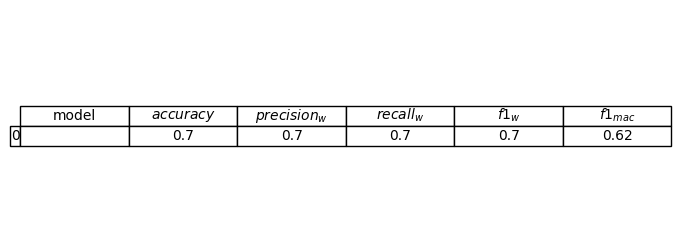

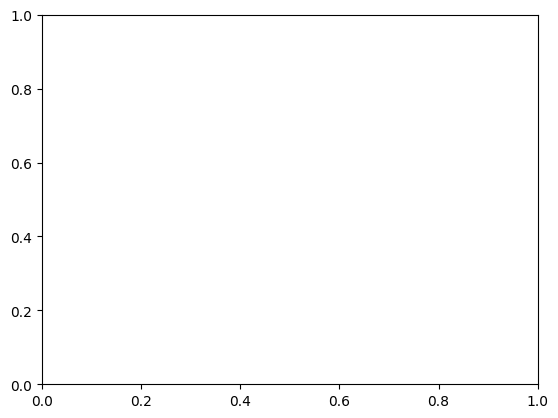

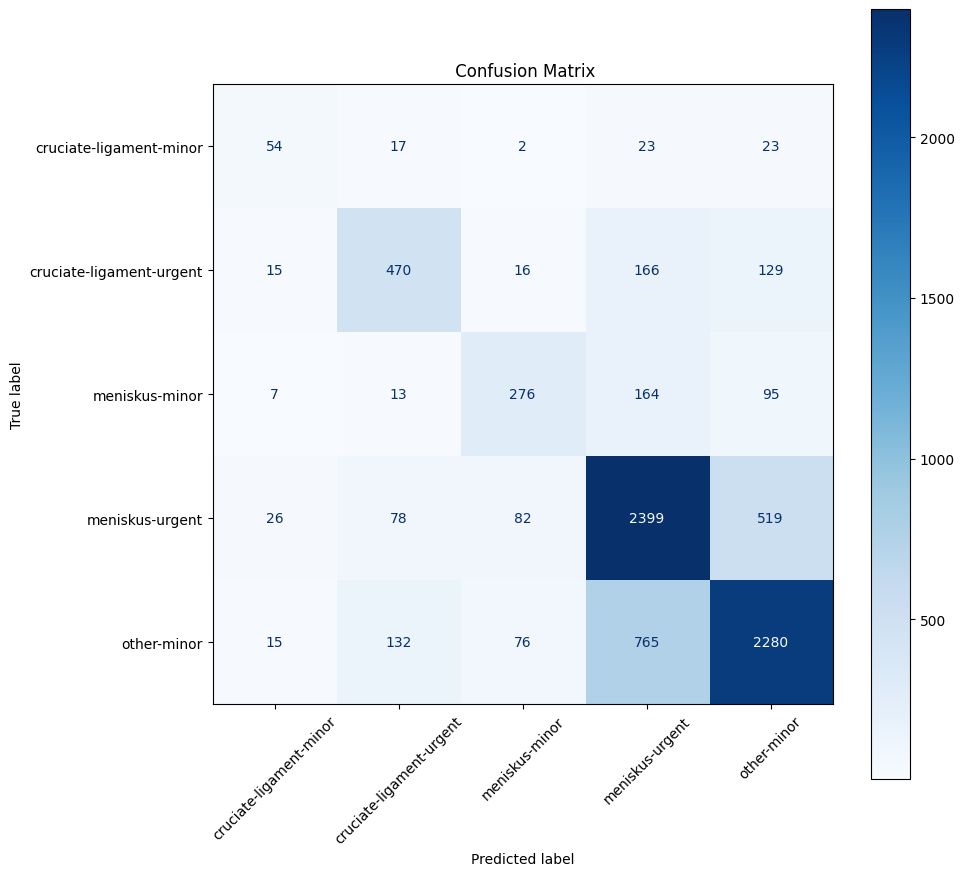

,model,$accuracy$,$precision_{w}$,$recall_{w}$,$f1_{w}$,$f1_{mac}$
0,,0.7,0.7,0.7,0.7,0.62


In [10]:
eval(best_model, test_padded, test_labels, label_encoder)

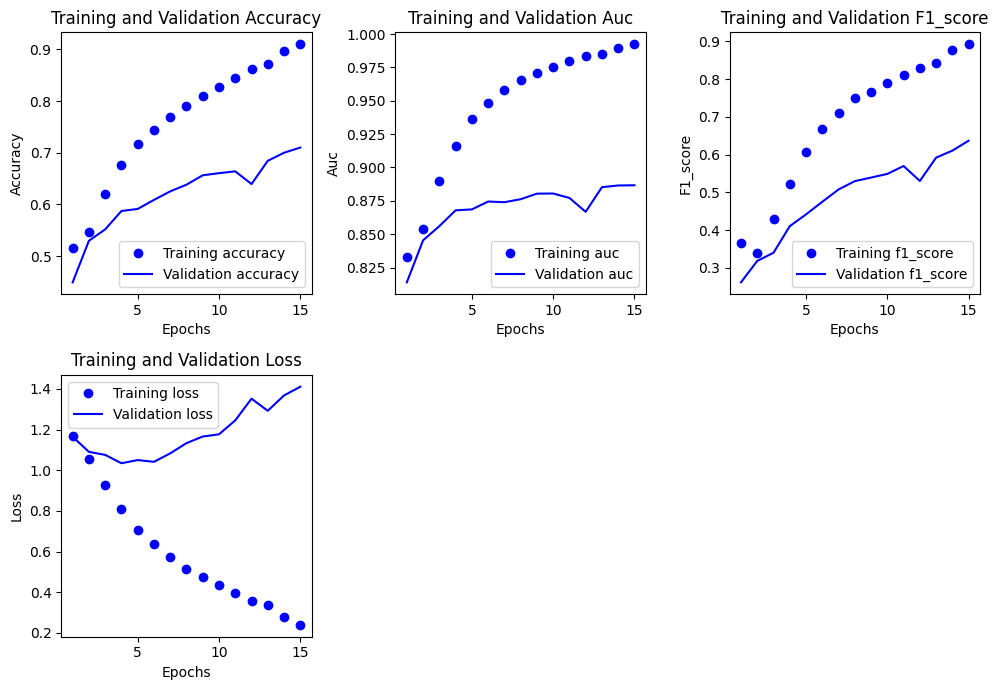

In [11]:
eval_training(history, metrics)